# TP 2: Image segmentation with Neural Network

## Objective:
- Introduction to Pytorch (see previous tutorial notebook)
- Define a simple neural network
- Define a training procedure
- Compare difference optimization methods
- Enhance your coding skills

We consider an image as a function from $\Omega$ to $\mathbb{R}$, where $\Omega$ is a discretization of the space $[0,1]^2$. In this notebook, we suppose that we can partition $\Omega$ into $2$ regular domains $\Omega_1$ and $\Omega_2 = \Omega /  \Omega_1$.

On each domain, we suppose that the image has different textures. We will generate these textures as stationary Gaussian processes:
- We will first generate a Gaussian noise. 
- We will then convolve this noise with a filter which describes the covariance matrix of the process. 



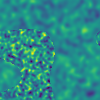
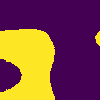


Above is an example of an image and its partition $\Omega_1$ and $\Omega_2$. The objective is from the image on the left, train a neural network to predict the mask on the right.

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

Define your device and data type

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
factory_kwargs = {'device': device, 'dtype': dtype}

print("factory_kwargs: ", factory_kwargs)

factory_kwargs:  {'device': device(type='cuda'), 'dtype': torch.float32}


In [4]:
device

device(type='cuda')

In [5]:
torch.manual_seed(42)

### Generating data

The following function will generate a batch of data with shape `(batch_size, 1, image_size, image_size)`
Take a look at this function and try to understand what it does. 

In [6]:
def generate_data(batch_size: int, 
                  image_size: int = 128, 
                  sigma1: float = 1., 
                  sigma2: float = 0.2, 
                  sigma: float = 25,
                  **factory_kwargs) -> torch.Tensor:
    
    # Defining a grid directly on device, without the need of calling `.to(device)` method,
    # which is time consuming.
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x,y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # We define a random smooth partition
    b = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution

    omega_1 = gp > 0
    omega_2 = ~omega_1
    
    # We define two Gaussian random processes with different statistics
    b1 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp1 = F.conv2d(b1, g1[None,None], padding = 'same')
    
    b2 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp2 = F.conv2d(b2, g2[None,None], padding = 'same')
    
    # Now we put each process at the right place
    image = gp1 * omega_1 + gp2 * omega_2
    # We smooth the result to avoid having a jump at the interfaces
    image =  F.conv2d(image, g3[None,None], padding = 'same')

    # We normalize the image in to [0,1]
    image = normalize_to_01(image)
    
    return image, omega_1.to(**factory_kwargs)
    

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim = (-2, -1), keepdim=True)
    input /= input.amax(dim = (-2, -1), keepdim=True)
    return input

Let's take a look at the data and its structure

/tmp/ipykernel_6607/3741924848.py:31: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution


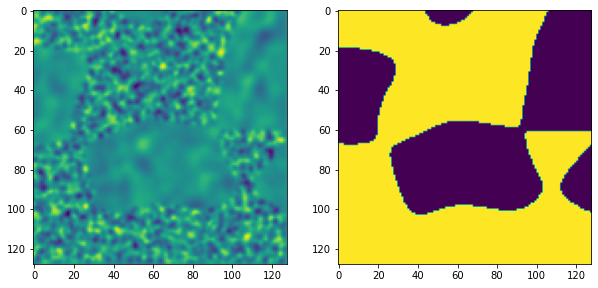

In [7]:
image, mask = generate_data(batch_size = 1, 
                            image_size=128,
                            sigma1=0.2,
                            sigma2=2.5, 
                            sigma=15, **factory_kwargs)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
plt.show()

In [8]:
print("image.shape: ", image.shape)
print("mask.shape: ", mask.shape)

print(mask[0])

image.shape:  torch.Size([1, 1, 128, 128])
mask.shape:  torch.Size([1, 1, 128, 128])
tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0')


A more efficient way to generate a 2D Gaussian is in following, let have a look at this function and try to understand the difference.

In [9]:
def gaussian(image_size, sigma, **factory_kwargs):
    linspace = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    distance = linspace[None,:] ** 2 + linspace[:,None] ** 2
    
    # Defining 4 Gaussian
    g = torch.exp(-distance / (2 * sigma**2))
    g = g / torch.sum(g)

    return g

# Question 3.2

**Role respectif de sigma1,sigma2,sigma :**



- *`sigma1` et `sigma2` contrôlent les écarts-types des fonctions gaussiennes associées à deux processus aléatoires différents.*
- *`sigma` contrôle l'écart-type de la fonction gaussienne principale utilisée dans la génération initiale des données.*

*Ajuster ces paramètres vous permet de contrôler la régularité et les caractéristiques des données synthétiques générées par la fonction.*

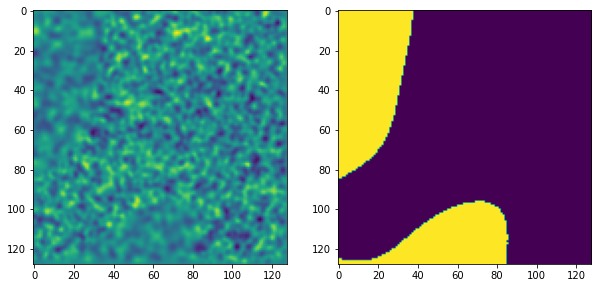

In [10]:
image, mask = generate_data(batch_size = 1, 
                            image_size=128,
                            sigma1=1.2,
                            sigma2=0.5, 
                            sigma=20, **factory_kwargs)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
plt.show()

# Question 3.3

le problème d'identification semble difficile pour des sigmas telle que
sigma1,sigma2<<0.1
A faire

## Define your neural network

In [11]:
class MyFirtsCNN(nn.Module):
    def __init__(self, num_channels=16, kernel_size = 5, bias=True):
        super().__init__()

        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm2d(num_channels)
        self.bias = bias
        self.kernel_size = kernel_size
        self.pad = int((self.kernel_size - 1) / 2)
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=bias,
            ),
            self.activation,
            self.bn
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_channels,
                out_channels=num_channels,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
            ),
            self.activation,
            self.bn
        )

        self.out = nn.Conv2d(
                in_channels=num_channels,
                out_channels=1,
                kernel_size=self.kernel_size,
                stride=1,
                padding=self.pad,
                bias=self.bias,
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        output = torch.sigmoid(self.out(x3))
        return output


### Question: How many layers do we have in the network? What are the activation functions?

Il y a 3 couches de convolution dans ce réseau de neuronnes et les fonctions d'activation est la fonction ReLu() pour les couches et la dernière est une sigmoid.

### Question : Explain why we have a `sigmoid` activation at the end of the network? Write the training optimization problem.

On utilise une fonction sigmoïde comme activation pour la dernière couche, étant donné que nous effectuons une classification en deux classes distinctes. Puisque nous renvoyons une sortie binaire, l'utilisation de la sigmoïde est suffisante dans ce contexte.

In [12]:
model = MyFirtsCNN(num_channels=16, kernel_size = 5)

In [13]:
model

MyFirtsCNN(
  (activation): ReLU()
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Conv2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

Let see how many parameters you have in your model.

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters: ", count_parameters(model))

Number of parameters:  13681


In [15]:

# By default, the model (i.e., the trainable parameters) is stored in CPU
print(next(model.parameters()).device)
# You have to push your to GPU if you want to use GPU
model = model.to(device)
print(next(model.parameters()).device)


cpu
cuda:0


### Question: Verify your model output shape? The link with the input shape?

In [16]:
print("Input shape: ", image.shape)
print("Output shape: ", model.forward(image).shape) # a retenir model(image)==model.forward(image)

Input shape:  torch.Size([1, 1, 128, 128])
Output shape:  torch.Size([1, 1, 128, 128])


## Define your optimization algorithm

The optimization algorithms are defined in `torch.optim`. We need to pass all the trainable parameters to the optimizer, along with other hyperparameters such as the learning rate, ...

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer_bis = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer_ter = torch.optim.RMSProp(model.parameters(), lr=0.001)


## Training the model

Define your training hyperparameters

In [18]:
from tqdm.auto import tqdm

Below is an example of how to train a neural network. Look at these line of code carefully and understand what is does. 

  0%|          | 0/10000 [00:00<?, ?it/s]

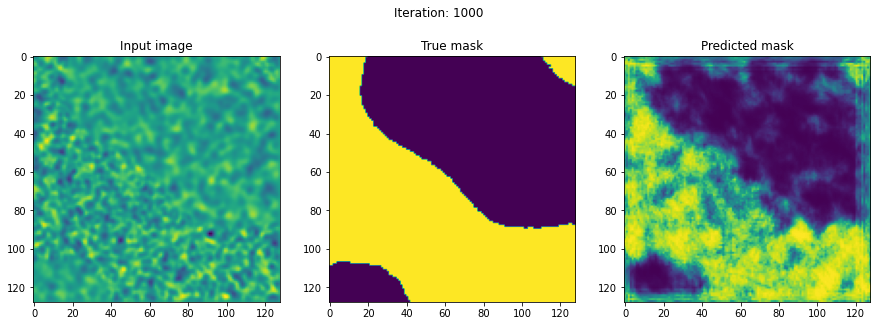

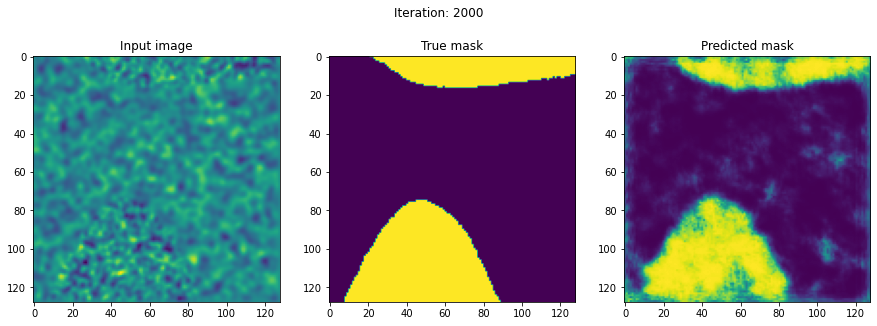

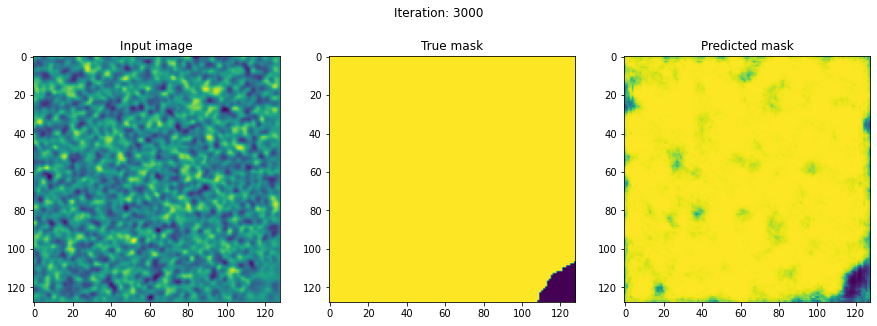

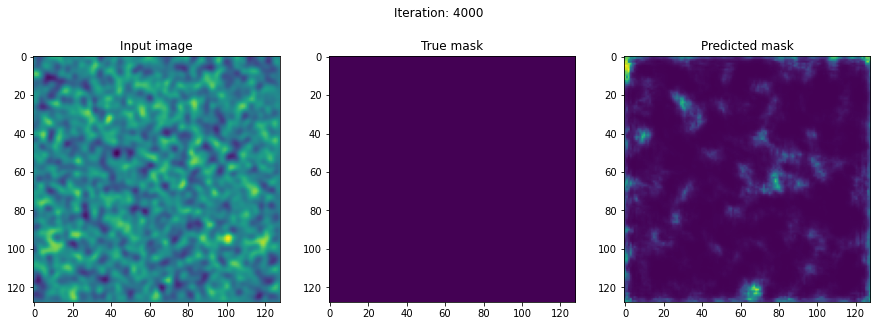

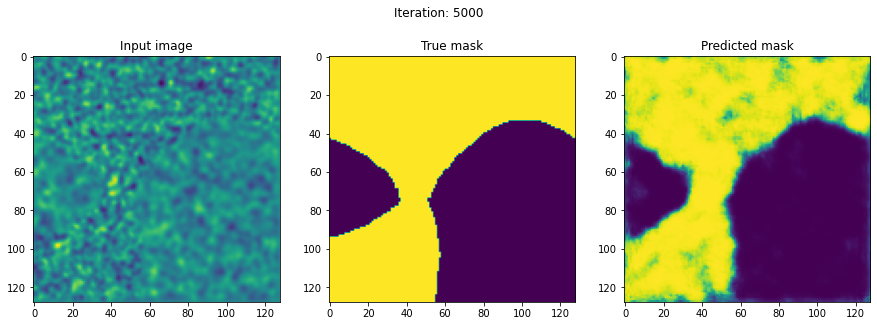

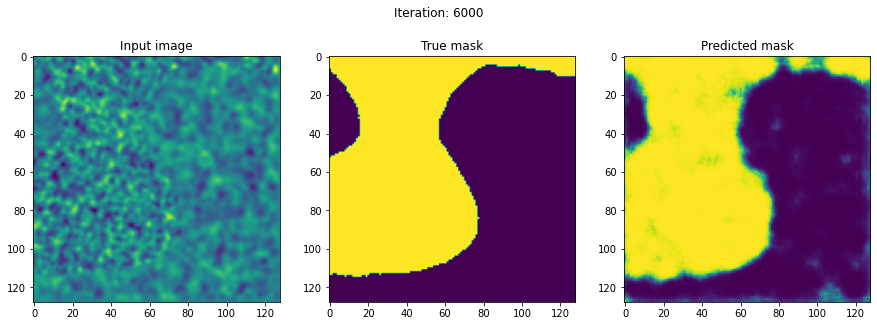

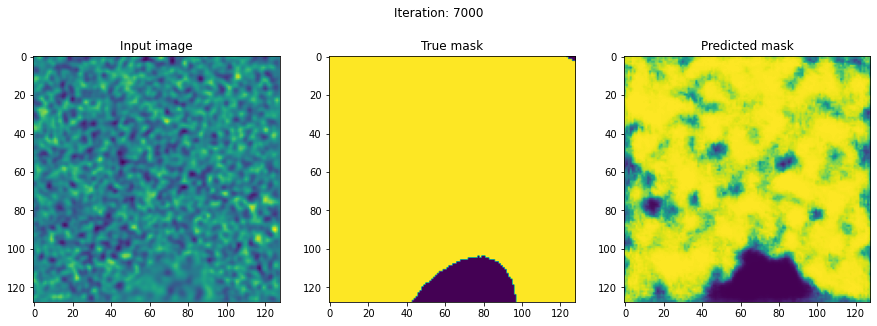

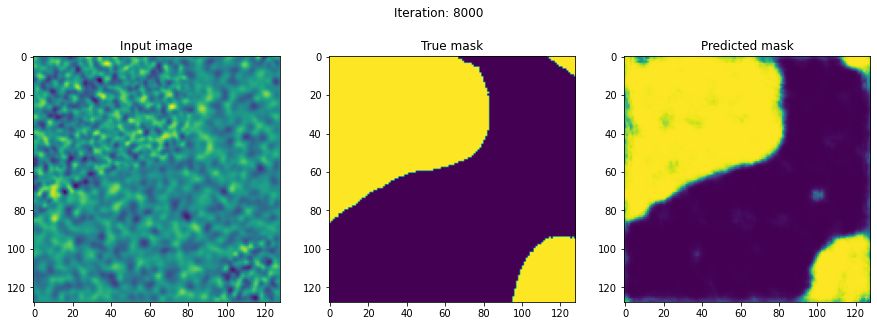

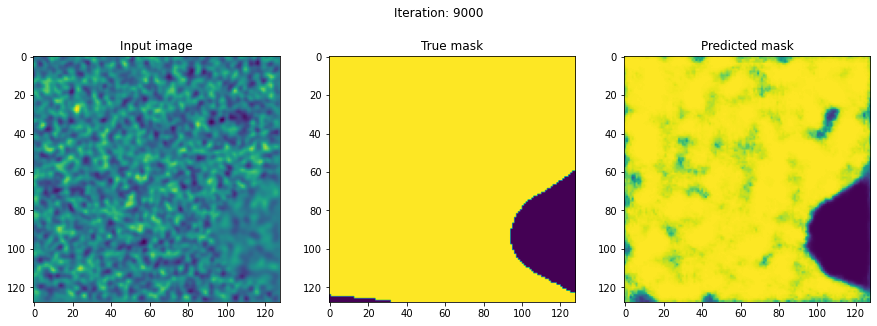

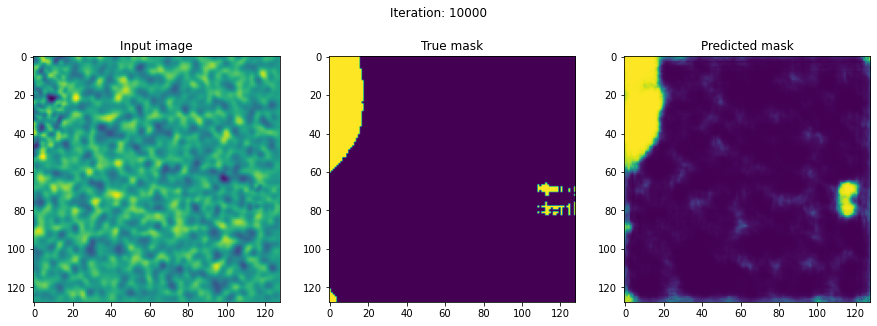

In [19]:
num_train_iteration = 10000
batch_size = 8
display_prediction_every = 1000
image_size = 128
sigma1 = 0.2
sigma2 = 1.2
sigma = image_size / 5


t = tqdm(range(num_train_iteration))
avg_loss = 0
loss_tracking = []

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)

    # Step 1: 
    """   
    Elle parcourt tous les paramètres (poids) du modèle associés à l'optimiseur.
    Elle met à zéro les gradients associés à chaque paramètre."""
    optimizer.zero_grad()

    # Step 2: 
    """
    Cette étape prédit à l'aide du modèle
    """
    predicted_omega_1 = model(x)

    # Step 3:...
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )

    # Step 4:...
    loss.backward()

    # Step 5:...
    optimizer.step()

    # Tracking 
    avg_loss += loss.item()
    loss_tracking.append(avg_loss / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

In [20]:
import matplotlib.image as mpimg

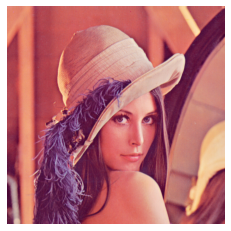

In [21]:
image = mpimg.imread("test_image.png")

# Afficher l'image
plt.imshow(image)
plt.axis('off')  # Masquer les axes
plt.show()

In [22]:
img_128 = image[256:384,256:384,:]

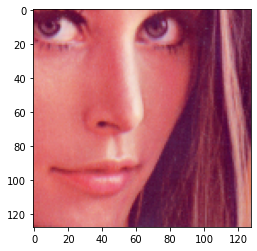

In [23]:
plt.imshow(img_128)


In [24]:
def generate_data(batch_size: int, 
                  image_size: int = 128, 
                  sigma1: float = 1., 
                  sigma2: float = 0.2, 
                  sigma: float = 25,
                  **factory_kwargs) -> torch.Tensor:
    
    # Defining a grid directly on device, without the need of calling `.to(device)` method,
    # which is time consuming.
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x,y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # We define a random smooth partition
    b = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution
    
    omega_1 = gp > 0
    omega_2 = ~omega_1
    
    # We define two Gaussian random processes with different statistics
    b1 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp1 = F.conv2d(b1, g1[None,None], padding = 'same')
    
    b2 = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
    gp2 = F.conv2d(b2, g2[None,None], padding = 'same')
    
    # Now we put each process at the right place
    image = gp1 * omega_1 + gp2 * omega_2
    # We smooth the result to avoid having a jump at the interfaces
    image =  F.conv2d(image, g3[None,None], padding = 'same')

    # We normalize the image in to [0,1]
    image = normalize_to_01(image)
    
    return image, omega_1.to(**factory_kwargs)
    

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim = (-2, -1), keepdim=True)
    input /= input.amax(dim = (-2, -1), keepdim=True)
    return input

In [25]:
image_size = 128
xs = torch.linspace(-i/2, image_size/2, image_size, **factory_kwargs)
ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

# The type of x,y below is automatically in device and dtype of x, y.
x, y = torch.meshgrid(xs, ys, indexing='xy')

# Defining 4 Gaussian
g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
g = g / torch.sum(g)

In [40]:
img_128.shape

(128, 128, 3)

In [49]:
# b = torch.randn(batch_size,1,image_size,image_size, **factory_kwargs)
# b.shape
b = torch.tensor(img_128).unsqueeze(0)
gp = F.conv2d(b, g[None,None], padding = 'same')  # Convolution

RuntimeError: Given groups=1, weight of size [1, 1, 128, 128], expected input[1, 128, 129, 4] to have 1 channels, but got 128 channels instead

In [52]:
g[None,None].shape
g.shape

torch.Size([128, 128])

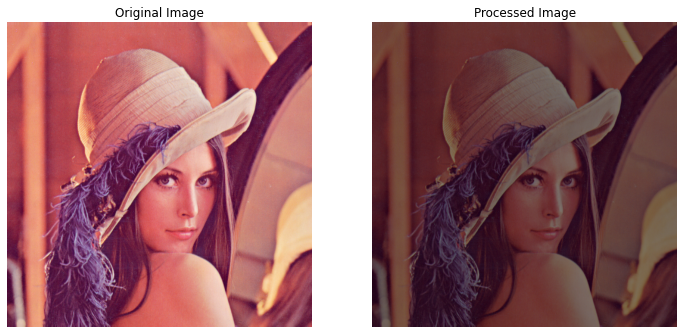

In [56]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def generate_data_on_image(image: torch.Tensor, 
                           sigma1: float = 1., 
                           sigma2: float = 0.2, 
                           sigma: float = 25,
                           **factory_kwargs) -> torch.Tensor:
    
    batch_size, channels, image_size, _ = image.shape

    # Defining a grid directly on device
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x, y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # Initialize the result image
    result_image = torch.zeros_like(image)

    for c in range(channels):
        # We define a random smooth partition
        b = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp = F.conv2d(b, g[None,None], padding='same')  # Convolution
        
        omega_1 = gp > 0
        omega_2 = ~omega_1
        
        # We define two Gaussian random processes with different statistics
        b1 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp1 = F.conv2d(b1, g1[None,None], padding='same')
        
        b2 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp2 = F.conv2d(b2, g2[None,None], padding='same')
        
        # Now we put each process at the right place
        channel_image = gp1 * omega_1 + gp2 * omega_2
        # We smooth the result to avoid having a jump at the interfaces
        channel_image = F.conv2d(channel_image, g3[None,None], padding='same')

        # Normalize the channel image to [0,1]
        channel_image = normalize_to_01(channel_image)

        # Combine the original image channel with the generated channel image
        result_image[:, c, :, :] = (image[:, c, :, :] + channel_image.squeeze(1)) / 2
    
    return result_image

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim=(-2, -1), keepdim=True)
    input /= input.amax(dim=(-2, -1), keepdim=True)
    return input

# Load an image
image_path = "test_image.png"
image_pil = Image.open(image_path).convert('RGB')
image_np = np.array(image_pil)
image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).float()  # Convert to NCHW format and add batch dimension

# Apply the random process to the image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
processed_image_tensor = generate_data_on_image(image_tensor, device=device)

# Convert the processed image back to numpy for visualization
processed_image_np = processed_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Display the original and processed images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(processed_image_np.astype(np.uint8))
axs[1].set_title('Processed Image')
axs[1].axis('off')

plt.show()


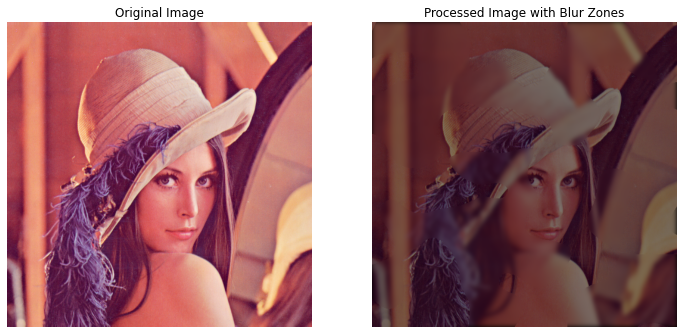

In [59]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def create_blur_kernel(kernel_size: int = 25) -> torch.Tensor:
    # Create a 2D Gaussian kernel
    x = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    y = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    x, y = torch.meshgrid(x, y, indexing='xy')
    sigma = kernel_size / 6  # Standard deviation
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()  # Normalize
    return kernel

def blur_image(image: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    batch_size, channels, height, width = image.shape
    kernel = kernel.expand(channels, 1, kernel.shape[2], kernel.shape[3])
    padding = kernel.shape[-1] // 2
    blurred_image = F.conv2d(image, kernel, padding=padding, groups=channels)
    return blurred_image

def generate_data_on_image(image: torch.Tensor, 
                           sigma1: float = 1., 
                           sigma2: float = 0.2, 
                           sigma: float = 25,
                           **factory_kwargs) -> torch.Tensor:
    
    batch_size, channels, image_size, _ = image.shape

    # Defining a grid directly on device
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x, y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # Initialize the result image
    result_image = torch.zeros_like(image)

    for c in range(channels):
        # We define a random smooth partition
        b = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp = F.conv2d(b, g[None,None], padding='same')  # Convolution
        
        omega_1 = gp > 0
        omega_2 = ~omega_1
        
        # We define two Gaussian random processes with different statistics
        b1 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp1 = F.conv2d(b1, g1[None,None], padding='same')
        
        b2 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp2 = F.conv2d(b2, g2[None,None], padding='same')
        
        # Now we put each process at the right place
        channel_image = gp1 * omega_1 + gp2 * omega_2
        # We smooth the result to avoid having a jump at the interfaces
        channel_image = F.conv2d(channel_image, g3[None,None], padding='same')

        # Normalize the channel image to [0,1]
        channel_image = normalize_to_01(channel_image)

        # Combine the original image channel with the generated channel image
        result_image[:, c, :, :] = (image[:, c, :, :] + channel_image.squeeze(1)) / 2
    
    return result_image, omega_1.float()  # Convert omega_1 to float

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim=(-2, -1), keepdim=True)
    input /= input.amax(dim=(-2, -1), keepdim=True)
    return input

def apply_blur_zones(image: torch.Tensor, omega: torch.Tensor, kernel_size: int = 25) -> torch.Tensor:
    blur_kernel = create_blur_kernel(kernel_size).unsqueeze(0).unsqueeze(0).to(image.device)
    blurred_image = blur_image(image, blur_kernel)
    
    blurred_zones = omega * blurred_image
    non_blurred_zones = (1 - omega) * image
    
    final_image = blurred_zones + non_blurred_zones
    return final_image

# Load an image
image_path = "test_image.png"
image_pil = Image.open(image_path).convert('RGB')
image_np = np.array(image_pil)
image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).float()  # Convert to NCHW format and add batch dimension

# Apply the random process to the image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
processed_image_tensor, omega = generate_data_on_image(image_tensor, device=device)

# Apply blur to specific zones
blurred_image_tensor = apply_blur_zones(processed_image_tensor, omega, kernel_size=25)

# Convert the processed image back to numpy for visualization
blurred_image_np = blurred_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

# Display the original and processed images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(blurred_image_np)
axs[1].set_title('Processed Image with Blur Zones')
axs[1].axis('off')

plt.show()


#### Question: What is the loss function used here? If you have any idea about the loss function, don't hesitate to change it.

See the evolution of the average loss over the training process.

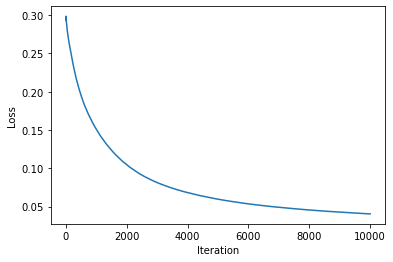

In [26]:
plt.plot(loss_tracking)
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()

If you are satisfied with the result, save your model:

In [27]:
state_dict = model.state_dict()
torch.save(state_dict, "best_model_bis.pt")

## Practical section: Train your best model
See the influence of each parameter:
- `sigma1`, `sigma2` and `sigma` are parameters which difine the difficulty of the problem.

And

- Try different optimizers and learning rates (see `torch.optim` in [this link](https://pytorch.org/docs/stable/optim.html#algorithms) ). Compare the performance. 
- What happens if the learning rate is too large? too small?
- How to evaluate the performance of your model?
- With a limit training time, try to train your best model.


In [28]:
sigma1=0.01
sigma2=0.1
sigma3=0.1

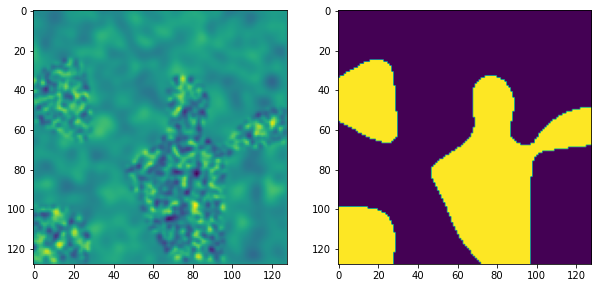

In [29]:
image, mask = generate_data(batch_size = 1, 
                            image_size=128,
                            sigma1=0.2,
                            sigma2=2.5, 
                            sigma=15, **factory_kwargs)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image[0].permute(1,2,0).detach().cpu().numpy())
axes[1].imshow(mask[0].permute(1,2,0).detach().cpu().numpy())
plt.show()

In [30]:
model = MyFirtsCNN(num_channels=16, kernel_size = 5)

In [31]:

# By default, the model (i.e., the trainable parameters) is stored in CPU
print(next(model.parameters()).device)
# You have to push your to GPU if you want to use GPU
model = model.to(device)
print(next(model.parameters()).device)

cpu
cuda:0


In [32]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/10000 [00:00<?, ?it/s]

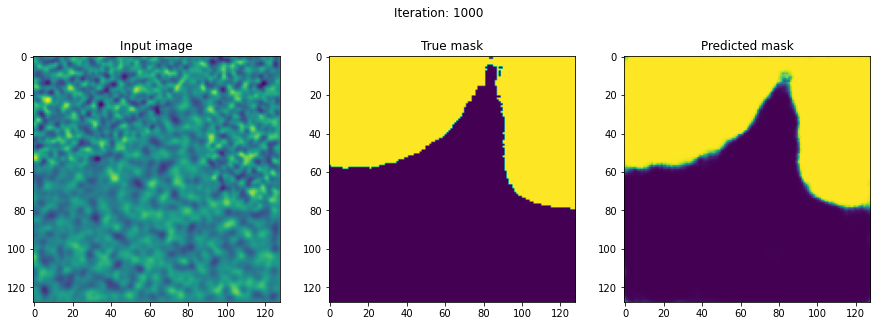

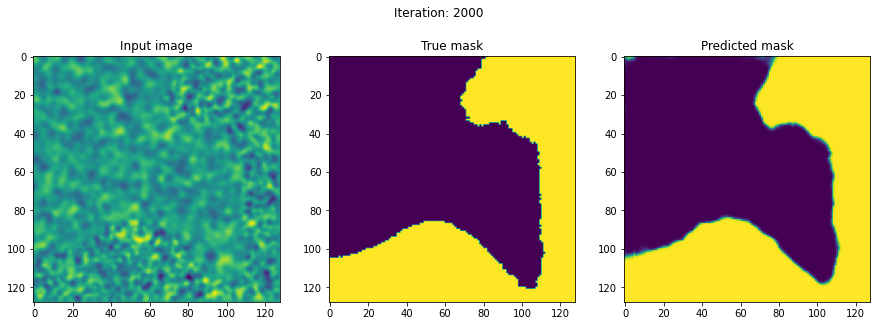

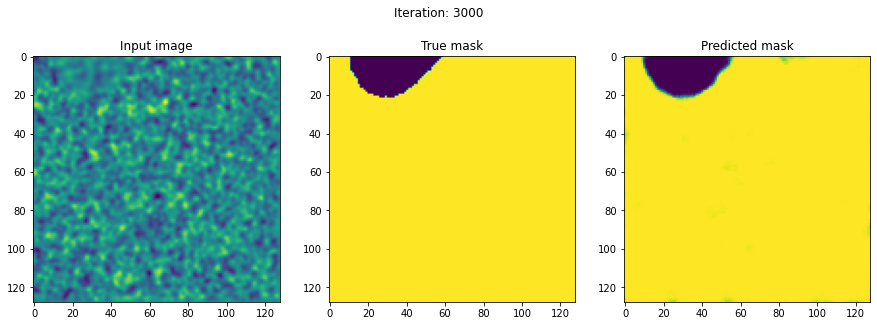

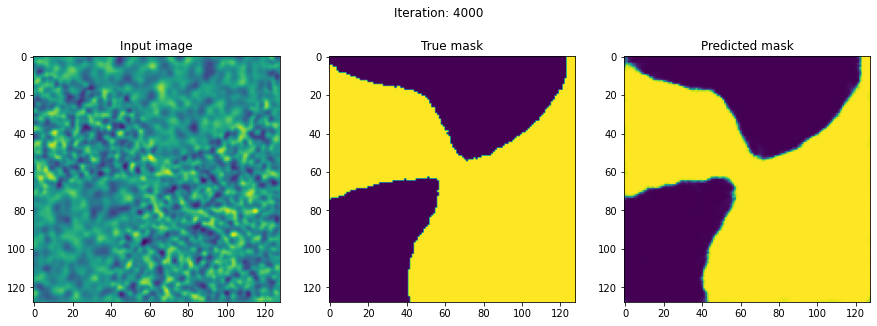

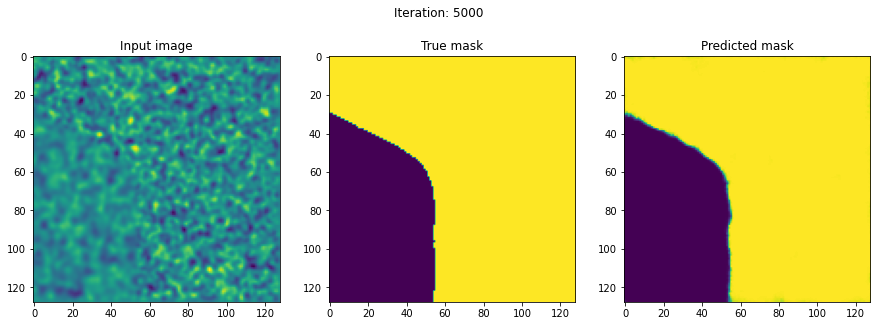

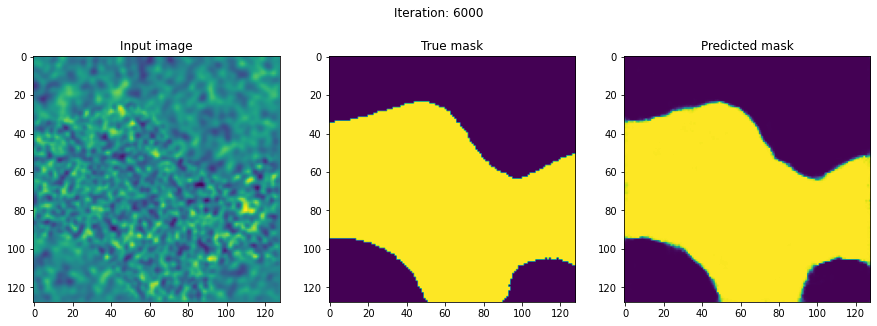

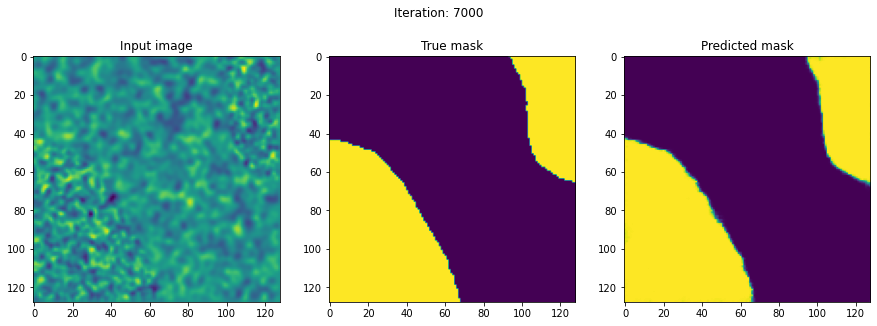

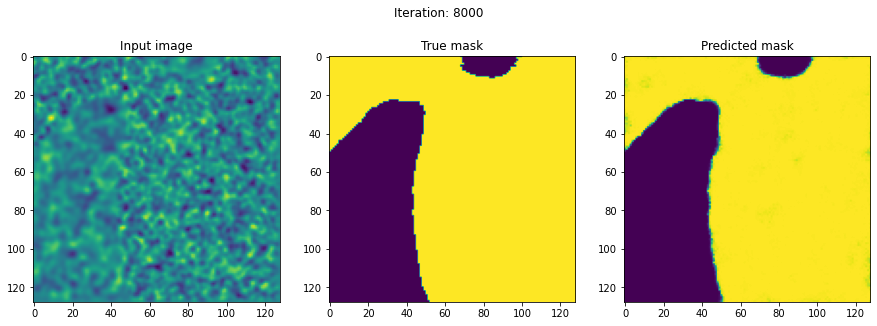

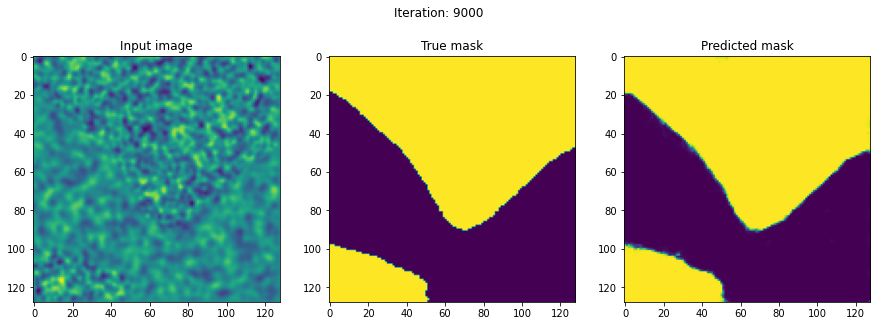

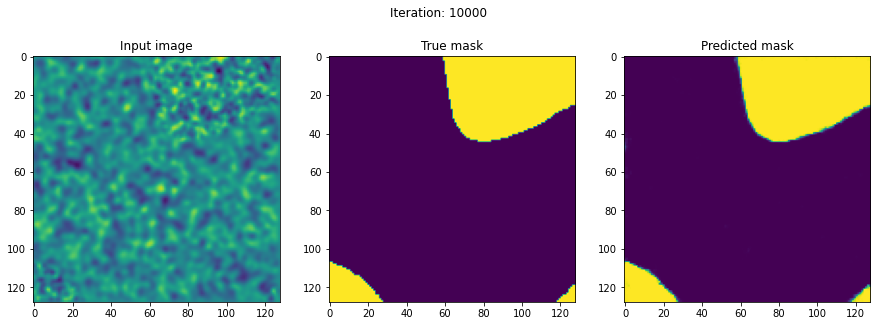

In [33]:
num_train_iteration = 10000
batch_size = 8
display_prediction_every = 1000
image_size = 128
sigma1 = 0.2
sigma2 = 1.2
sigma = image_size / 5


t = tqdm(range(num_train_iteration))
avg_loss = 0
loss_tracking = []

for i in t:
    x, omega_1 = generate_data(batch_size, image_size, sigma1, sigma2, sigma, **factory_kwargs)

    # Step 1: ...
    optimizer.zero_grad()

    # Step 2: ...
    predicted_omega_1 = model(x)

    # Step 3:...
    loss = torch.mean((predicted_omega_1 - omega_1) ** 2 )

    # Step 4:...
    loss.backward()

    # Step 5:...
    optimizer.step()

    # Tracking 
    avg_loss += loss.item()
    loss_tracking.append(avg_loss / (i + 1))
    t.set_description(f"Iteration: {i + 1}, Loss: {avg_loss / (i + 1):.4e}")

    if (i + 1) % display_prediction_every == 0:
        # Turn off the gradient tracking for better performance
        # since we don't need to track the gradients for this step
        with torch.no_grad():
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            axes[0].imshow(x[0,0].detach().cpu().numpy())
            axes[0].set_title("Input image")

            axes[1].imshow(omega_1[0,0].detach().cpu().numpy())
            axes[1].set_title("True mask")

            axes[2].imshow(predicted_omega_1[0,0].detach().cpu().numpy())
            axes[2].set_title("Predicted mask")
            plt.suptitle("Iteration: {}".format(i + 1))
            plt.show()

In [129]:
state_dict = model.state_dict()
torch.save(state_dict, "best_model_pnp.pth")

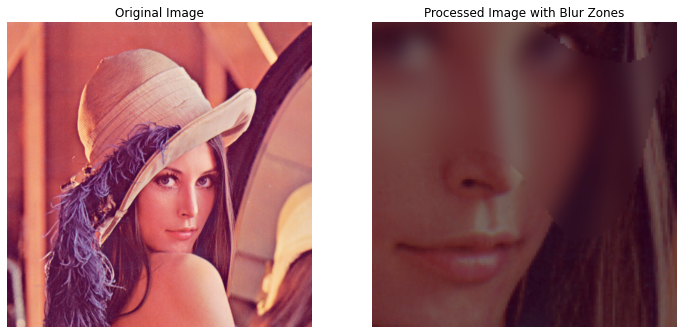

In [130]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def create_blur_kernel(kernel_size: int = 25) -> torch.Tensor:
    # Create a 2D Gaussian kernel
    x = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    y = torch.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    x, y = torch.meshgrid(x, y, indexing='xy')
    sigma = kernel_size / 6  # Standard deviation
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / kernel.sum()  # Normalize
    return kernel

def blur_image(image: torch.Tensor, kernel: torch.Tensor) -> torch.Tensor:
    batch_size, channels, height, width = image.shape
    kernel = kernel.expand(channels, 1, kernel.shape[2], kernel.shape[3])
    padding = kernel.shape[-1] // 2
    blurred_image = F.conv2d(image, kernel, padding=padding, groups=channels)
    return blurred_image

def generate_data_on_image(image: torch.Tensor, 
                           sigma1: float = 1., 
                           sigma2: float = 0.2, 
                           sigma: float = 25,
                           **factory_kwargs) -> torch.Tensor:
    
    batch_size, channels, image_size, _ = image.shape

    # Defining a grid directly on device
    xs = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)
    ys = torch.linspace(-image_size/2, image_size/2, image_size, **factory_kwargs)

    # The type of x, y below is automatically in device and dtype of x, y.
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    
    # Defining 4 Gaussian
    g = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    g = g / torch.sum(g)
    
    g1 = torch.exp(-(x**2 + y**2) / (2 * sigma1**2))
    g1 = g1 / torch.sum(g1)

    g2 = torch.exp(-(x**2 + y**2) / (2 * sigma2**2))
    g2 = g2 / torch.sum(g2)

    g3 = torch.exp(-(x**2 + y**2) / (2 * 1**2))
    g3 = g3 / torch.sum(g3)
    
    # Initialize the result image
    result_image = torch.zeros_like(image)

    for c in range(channels):
        # We define a random smooth partition
        b = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp = F.conv2d(b, g[None,None], padding='same')  # Convolution
        
        omega_1 = gp > 0
        omega_2 = ~omega_1
        
        # We define two Gaussian random processes with different statistics
        b1 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp1 = F.conv2d(b1, g1[None,None], padding='same')
        
        b2 = torch.randn(batch_size, 1, image_size, image_size, **factory_kwargs)
        gp2 = F.conv2d(b2, g2[None,None], padding='same')
        
        # Now we put each process at the right place
        channel_image = gp1 * omega_1 + gp2 * omega_2
        # We smooth the result to avoid having a jump at the interfaces
        channel_image = F.conv2d(channel_image, g3[None,None], padding='same')

        # Normalize the channel image to [0,1]
        channel_image = normalize_to_01(channel_image)

        # Combine the original image channel with the generated channel image
        result_image[:, c, :, :] = (image[:, c, :, :] + channel_image.squeeze(1)) / 2
    
    return result_image, omega_1.float()  # Convert omega_1 to float

def normalize_to_01(input: torch.Tensor) -> torch.Tensor:
    input -= input.amin(dim=(-2, -1), keepdim=True)
    input /= input.amax(dim=(-2, -1), keepdim=True)
    return input

def apply_blur_zones(image: torch.Tensor, omega: torch.Tensor, kernel_size: int = 25) -> torch.Tensor:
    blur_kernel = create_blur_kernel(kernel_size).unsqueeze(0).unsqueeze(0).to(image.device)
    blurred_image = blur_image(image, blur_kernel)
    
    blurred_zones = omega * blurred_image
    non_blurred_zones = (1 - omega) * image
    
    final_image = blurred_zones + non_blurred_zones
    return final_image

# Load an image
image_path = "test_image.png"
image_pil = Image.open(image_path).convert('RGB')
image_np = np.array(image_pil)
image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).float()  # Convert to NCHW format and add batch dimension

# Apply the random process to the image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
processed_image_tensor, omega = generate_data_on_image(image_tensor, device=device)

# Apply blur to specific zones
blurred_image_tensor = apply_blur_zones(processed_image_tensor, omega, kernel_size=25)

# Convert the processed image back to numpy for visualization
blurred_image_np = blurred_image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)

# Display the original and processed images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(blurred_image_np[256:384,256:384,:])
axs[1].set_title('Processed Image with Blur Zones')
axs[1].axis('off')

plt.show()


In [131]:
image_flou = torch.Tensor(blurred_image_np[256:384,256:384,:])

In [89]:
test = (image_flou/256).unsqueeze(0).permute(3,0,2,1)

In [91]:
test.device

device(type='cpu')

In [132]:
prediction = model((image_flou).unsqueeze(0).permute(3,0,1,2).to(device))

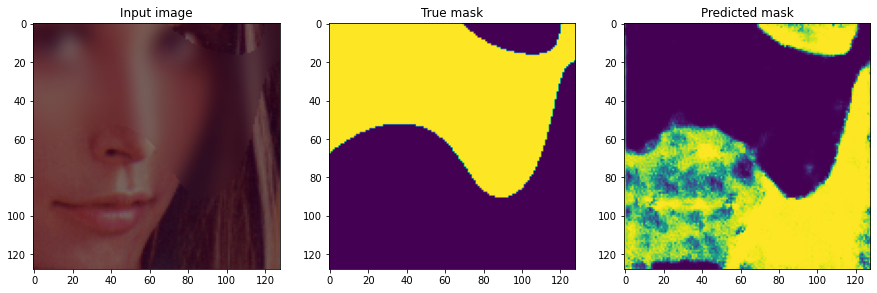

In [133]:



fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
axes[0].imshow(blurred_image_np[256:384,256:384,:])
axes[0].set_title("Input image")

axes[1].imshow(omega[0,0][256:384,256:384].detach().cpu().numpy())
axes[1].set_title("True mask")

axes[2].imshow(prediction[0,0].detach().cpu().numpy())
axes[2].set_title("Predicted mask")
plt.show()